<a href="https://colab.research.google.com/github/Bonzar/Homework/blob/buisness.lesson4/buisnass/4/%D0%94%D0%97_%E2%84%964.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-uplift catboost==0.22 -U
!pip install causalml

Requirement already up-to-date: scikit-uplift in /usr/local/lib/python3.7/dist-packages (0.3.1)
Requirement already up-to-date: catboost==0.22 in /usr/local/lib/python3.7/dist-packages (0.22)


In [2]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
path = '/gdrive/MyDrive/4/'

In [4]:
%matplotlib inline

import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklift.models import SoloModel, ClassTransformation, TwoModels
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures
from sklearn.pipeline import FeatureUnion

In [5]:
from sklearn.utils.validation import check_consistent_length
import matplotlib.pyplot as plt


def plot_uplift_preds_(trmnt_preds, ctrl_preds, log=False, bins=100):
    """Plot histograms of treatment, control and uplift predictions.

    Args:
        trmnt_preds (1d array-like): Predictions for all observations if they are treatment.
        ctrl_preds (1d array-like): Predictions for all observations if they are control.
        log (bool): Logarithm of source samples. Default is False.
        bins (integer or sequence): Number of histogram bins to be used. Default is 100.
            If an integer is given, bins + 1 bin edges are calculated and returned.
            If bins is a sequence, gives bin edges, including left edge of first bin and right edge of last bin.
            In this case, bins is returned unmodified. Default is 100.

    Returns:
        Object that stores computed values.
    """

    # TODO: Add k as parameter: vertical line on plots
    check_consistent_length(trmnt_preds, ctrl_preds)
  
    if not isinstance(bins, int) or bins <= 0:
        raise ValueError(
            f'Bins should be positive integer. Invalid value for bins: {bins}')

    if log:
        trmnt_preds = np.log(trmnt_preds + 1)
        ctrl_preds = np.log(ctrl_preds + 1)

    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 7))
    axes[0].hist(
        trmnt_preds, bins=bins, alpha=0.3, color='b', label='Treated', histtype='stepfilled')
    axes[0].set_ylabel('Probability hist')
    axes[0].legend()
    axes[0].set_title('Treatment predictions')

    axes[1].hist(
        ctrl_preds, bins=bins, alpha=0.5, color='y', label='Not treated', histtype='stepfilled')
    axes[1].legend()
    axes[1].set_title('Control predictions')

    axes[2].hist(
        trmnt_preds - ctrl_preds, bins=bins, alpha=0.5, color='green', label='Uplift', histtype='stepfilled')
    axes[2].legend()
    axes[2].set_title('Uplift predictions')

    return axes

In [6]:
df = pd.read_csv(path +'data.csv')#, index_col='client_id')

In [7]:
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [9]:
df = df.rename(columns={'conversion':'target', 'offer': 'treatment'})

In [10]:
df['treatment'] = [1 if el == 'No Offer' else 0 for el in df['treatment']]

In [11]:
df.describe()

,recency,history,used_discount,used_bogo,is_referral,treatment,target
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.332906,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.471257,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.3, random_state=123)

In [13]:
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        print('ohe')
        result = pd.get_dummies(X, prefix=self.key)
        for col_ in self.columns:
            if col_ not in result.columns:
                result[col_] = 0
        return result[self.columns]


class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

In [14]:
PowerT_rec_hist = Pipeline([
    ('selector', ColumnSelector(['recency', 'history'])),
    ('scaler', PowerTransformer(method='box-cox'))
])

In [15]:
OHE = Pipeline([
    ('selector', ColumnSelector(['zip_code', 'channel'])),
    ('OHE', OHEEncoder(key=['zip_code', 'channel']))
])

In [16]:
Other_feat = Pipeline([
    ('selector', ColumnSelector(['used_discount', 'used_bogo', 'is_referral']))
])

In [17]:
feats = FeatureUnion([
                      ('PowerT_rec_hist', PowerT_rec_hist),
                      ('OHE', OHE),
                      ('Other_feat', Other_feat)])

In [18]:
from sklift.metrics import uplift_at_k
from sklift.models import SoloModel, TwoModels, ClassTransformation
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

In [19]:
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

# SoloModel

In [20]:
sm = Pipeline([
    ('features',feats),
    ('classifier', SoloModel(LogisticRegression(C=0.1)))
])


sm = sm.fit(X_train.drop('treatment', axis=1), y_train, classifier__treatment=X_train['treatment'])

ohe


In [21]:
uplift_sm = sm.predict(X_test.drop('treatment', axis=1))

ohe


In [22]:
sm_score10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=X_test['treatment'], strategy='by_group', k=0.1)
sm_score20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=X_test['treatment'], strategy='by_group', k=0.2)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score10)
models_results['uplift@20%'].append(sm_score20)

In [23]:
sm_trmnt_preds = sm.named_steps['classifier'].trmnt_preds_
sm_ctrl_preds = sm.named_steps['classifier'].ctrl_preds_

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f418dbbe2d0>,
      dtype=object)

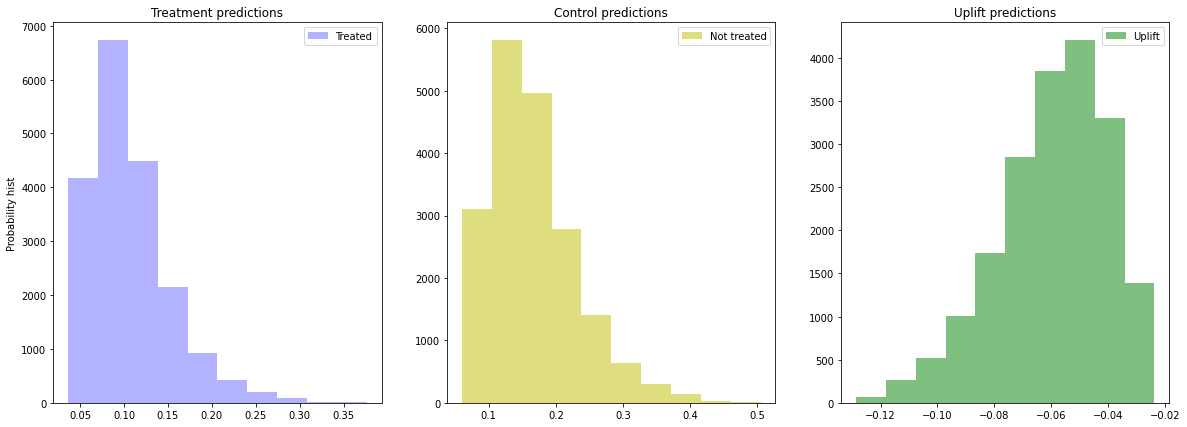

In [24]:
plot_uplift_preds_(sm_trmnt_preds, sm_ctrl_preds, bins=10)

# ClassTransformation

In [25]:
ct = Pipeline([
    ('features',feats),
    ('classifier', ClassTransformation(LogisticRegression(C=0.1)))
])


ct = ct.fit(X_train.drop('treatment', axis=1), y_train, classifier__treatment=X_train['treatment'])

ohe


/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  self._final_estimator.fit(Xt, y, **fit_params)


In [26]:
uplift_ct = ct.predict(X_test.drop('treatment', axis=1))

ohe


In [27]:
ct_score10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=X_test['treatment'], strategy='by_group', k=0.1)
ct_score20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=X_test['treatment'], strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransform')
models_results['uplift@10%'].append(ct_score10)
models_results['uplift@20%'].append(ct_score20)

# TwoModels

ohe
ohe


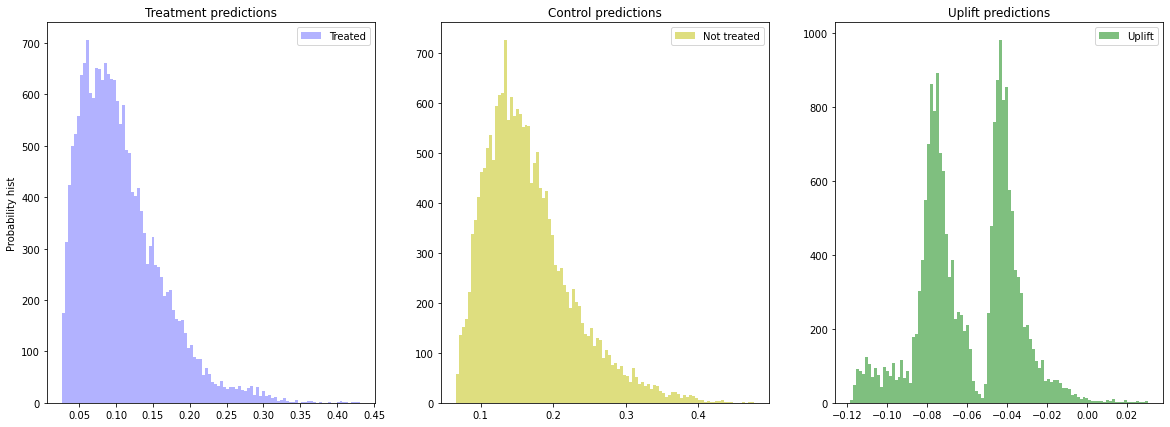

In [28]:
tm = TwoModels(
    estimator_trmnt=LogisticRegression(C=0.1), 
    estimator_ctrl=LogisticRegression(C=0.1), 
    method='vanilla'
  )

tm_pip = Pipeline([
    ('features',feats),
    ('classifier', tm)
])


tm = tm_pip.fit(
    X_train.drop('treatment', axis=1), y_train, classifier__treatment=X_train['treatment'] 
)

uplift_tm = tm.predict(X_test.drop('treatment', axis=1))

tm_score10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=X_test['treatment'], strategy='by_group', k=0.1)
tm_score20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=X_test['treatment'], strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score10)
models_results['uplift@20%'].append(tm_score20)

plot_uplift_preds_(trmnt_preds=tm.named_steps['classifier'].trmnt_preds_, ctrl_preds=tm.named_steps['classifier'].ctrl_preds_);

# Результаты

In [29]:
pd.DataFrame(data=models_results)[['approach','uplift@10%']].sort_values('uplift@10%', ascending=False)

,approach,uplift@10%
1,ClassTransform,-0.029744
0,SoloModel,-0.040671
2,TwoModels,-0.055627


In [30]:
pd.DataFrame(data=models_results)[['approach','uplift@20%']].sort_values('uplift@20%', ascending=False)

,approach,uplift@20%
2,TwoModels,-0.034441
0,SoloModel,-0.040267
1,ClassTransform,-0.041835
